# Feature Matching

## How It Works

Feature matching extracts defining key features from an input image using corner,edge and contour detection, them using distance calculation, finds matches in a secondary image.

### Methods

- Brute-force matching w/ ORB desc.;
- Brute-force matching w/ SIFT desc. and Ratio Test;
- FLANN based matcher.

In [56]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
def display(img, cmap="gray"):
    fig = plt.figure(figsize=(15,15))
    subplot = fig.add_subplot(111)
    subplot.imshow(img,cmap)

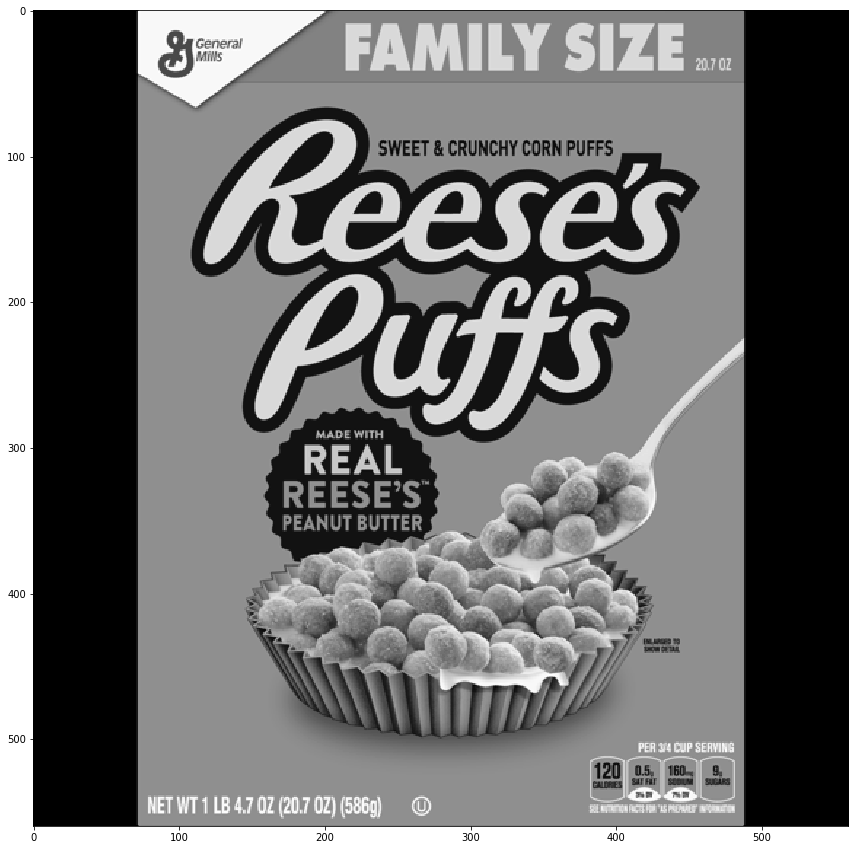

In [58]:
box_img = cv.imread("../assets/reeses_puffs.png", 0)
display(box_img)

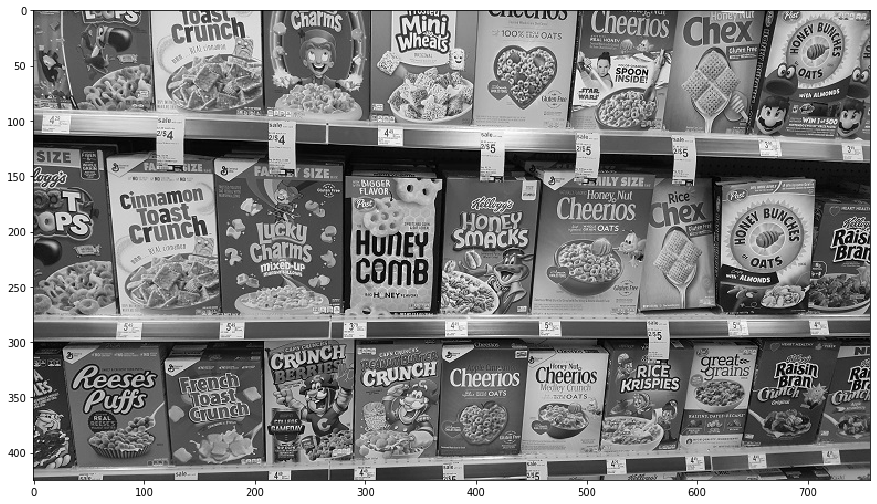

In [59]:
shelf_img = cv.imread('../assets/many_cereals.jpg', 0)
display(shelf_img)

## Brute-force w/ ORB

### ORB detector

This object detects and output features from images

In [61]:
orb = cv.ORB_create()

kp_box, descriptors_box = orb.detectAndCompute(box_img, None)
kp_shelf, descriptors_shelf = orb.detectAndCompute(shelf_img, None)

### Matching

We'll use cv.NORM_HAMMING, because it's the default matching algorithm.

In [62]:
bruteforce = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bruteforce.match(descriptors_box, descriptors_shelf)

#### Sorting the best matches

The **distance** match atributte classifies how good of a match it was. *The less distance, better the match!*

In [63]:
matches = sorted(matches, key= lambda match: match.distance)

### Displaying the Matches

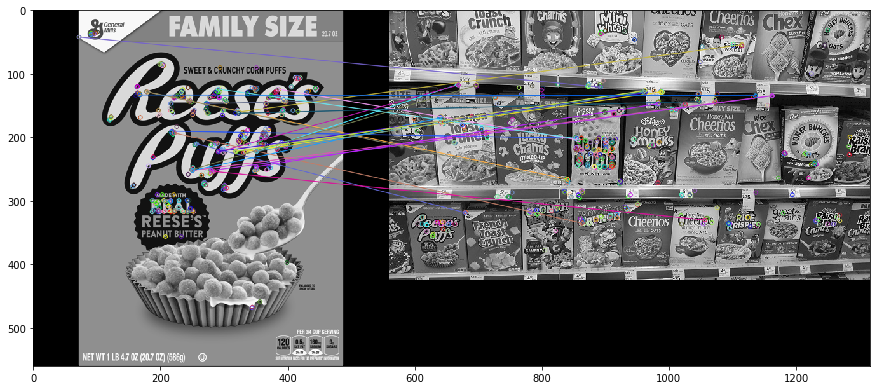

In [64]:
box_matches = cv.drawMatches(box_img, kp_box, shelf_img, kp_shelf, matches[:25], None, flags=0)
display(box_matches)

__Obs:__ This method of match don't perform very well

## Brute-force w/ SIFT

### SIFT detector

This is a NON FREE PACKAGE, i am using just for education purpose

In [65]:
sift = cv.xfeatures2d.SIFT_create()

kp_box, descriptors_box = sift.detectAndCompute(box_img, None)
kp_shelf, descriptors_shelf = sift.detectAndCompute(shelf_img, None)

## Matching

In [66]:
bruteforce = cv.BFMatcher()

In [67]:
matches = bruteforce.knnMatch(descriptors_box, descriptors_shelf, k=2) # It will find the K number best matches for each descriptor from a query

**Matches are pairs**, if the *first match of the pair* is close in distance to the *second match,of the pair* **this is a good match**

#### How do we check this? 

We apply a **ratio test**

In [68]:
good_matches = []

RATIO_BIAS = 0.75

# THIS IS A RATIO TEST
# LESS DISTANCE === BETTER MATCH
for match in matches:
    # IF MATCH 1 DISTANCE IS 75% OF MATCH 2 DISTANCE
    # THAN DESCRIPTOR IS A GOOD MATCH
    if match[0].distance < RATIO_BIAS*match[1].distance:
        good_matches.append(match)

In [69]:
len(good_matches), len(matches)

(79, 1503)

### Displaying the Matches

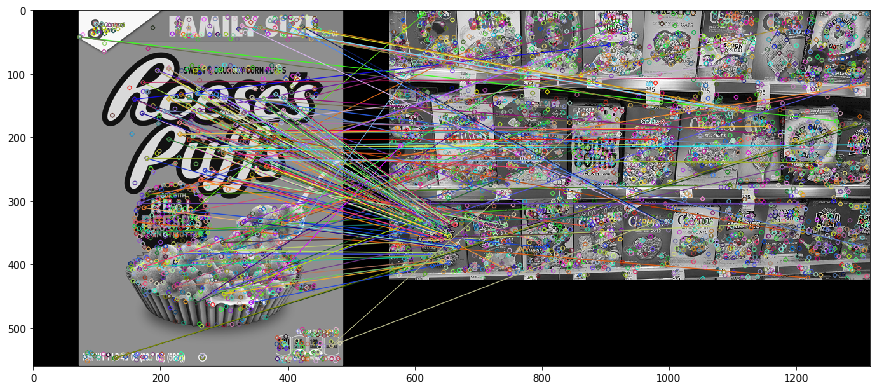

In [70]:
box_matches = cv.drawMatchesKnn(box_img, kp_box, shelf_img, kp_shelf, good_matches, None, flags=0)
display(box_matches)

## FLANN w SIFT

### SIFT detector

In [81]:
sift = cv.xfeatures2d.SIFT_create()

kp_box, descriptors_box = sift.detectAndCompute(box_img, None)
kp_shelf, descriptors_shelf = sift.detectAndCompute(shelf_img, None)

### Matching

FLANN is *Fast Library for Aprox. Nearst Neighboors*
This alg. is much faster than Brute-force, but doesn't find the best option just the general good matches.

In [82]:
FLANN_INDEX_KDTREE = 0
TREES = 5
CHECKS = 50

index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=TREES)
search_params = dict(checks=50)

In [83]:
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors_box, descriptors_shelf, k=2)

In [85]:
matches_mask = [[0,0] for i in range(len(matches))] # Just for apperance

In [86]:
RATIO_BIAS = 0.7

# THIS IS A RATIO TEST
for i, match in enumerate(matches):
    if match[0].distance < RATIO_BIAS*match[1].distance:
        matches_mask[i] = [1,0]

### Drawing the Matches

In this example we are using masks to identify the best options (green) against the other options (red)

In [91]:
draw_params = dict(matchColor=(0,255,0),
                    singlePointColor=(255,0,0),
                    matchesMask=matches_mask,
                    flags=0)

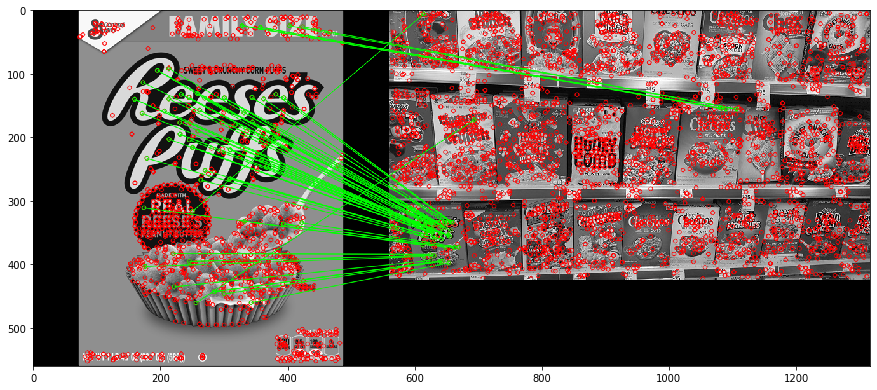

In [92]:
box_matches = cv.drawMatchesKnn(box_img, kp_box, shelf_img, kp_shelf, matches, None, **draw_params)
display(box_matches)